In [1]:
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
from highlight_text import ax_text
from matplotlib import colormaps

# https://github.com/mattharrison/datasets/raw/refs/heads/master/data/alta-noaa-1980-2019.csv
idx_colname = "DAY_OF_SEASON"
data_path = "alta-noaa-1980-2019.csv"
columns = ["DATE", "TOBS"]


def tweak_df(
    data_path: str, columns: list[str], idx_colname: str = "DAY_OF_SEASON"
):
    return (
        pl.scan_csv(data_path)
        .select(columns)
        .with_columns(
            pl.col("DATE").str.to_datetime(),
            pl.col("TOBS").interpolate(),
        )
        .sort("DATE")
        .with_columns(
            # Caveat: Cannot be placed in the previous `with_columns()`
            # due to different statuses of `TOBS`.
            pl.col("TOBS")
            .rolling_mean(window_size=28, center=True)
            .alias("TMEAN"),
            get_season_expr(col="DATE", alias="SEASON"),
        )
        .with_columns(
            add_day_of_season_expr(
                col="DATE", group_col="SEASON", alias=idx_colname
            )  #
        )
        .collect()
    )


def get_season_expr(col: str = "DATE", alias: str = "SEASON") -> pl.expr:
    return (
        (
            pl.when(
                (pl.col(col).dt.month().is_between(5, 10, closed="both"))
            )
            .then(pl.lit("Summer "))
            .otherwise(pl.lit("Ski "))
        )
        .add(
            pl.when(pl.col(col).dt.month() < 11)
            .then(pl.col(col).dt.year().cast(pl.String))
            .otherwise(pl.col(col).dt.year().add(1).cast(pl.String))
        )
        .alias(alias)
    )


def add_day_of_season_expr(
    col: str = "DATE",
    group_col: str = "SEASON",
    alias: str = "DAY_OF_SEASON",
) -> pl.expr:
    return (
        (pl.col(col) - pl.col(col).min())
        .dt.total_days()
        .over(group_col)
        .alias(alias)
    )


idx_colname = "DAY_OF_SEASON"
data_path = "alta-noaa-1980-2019.csv"
columns = ["DATE", "TOBS"]
print(tweak_df(data_path, columns))

shape: (14_160, 5)
┌─────────────────────┬──────┬───────┬─────────────┬───────────────┐
│ DATE                ┆ TOBS ┆ TMEAN ┆ SEASON      ┆ DAY_OF_SEASON │
│ ---                 ┆ ---  ┆ ---   ┆ ---         ┆ ---           │
│ datetime[μs]        ┆ f64  ┆ f64   ┆ str         ┆ i64           │
╞═════════════════════╪══════╪═══════╪═════════════╪═══════════════╡
│ 1980-01-01 00:00:00 ┆ 25.0 ┆ null  ┆ Ski 1980    ┆ 0             │
│ 1980-01-02 00:00:00 ┆ 18.0 ┆ null  ┆ Ski 1980    ┆ 1             │
│ 1980-01-03 00:00:00 ┆ 18.0 ┆ null  ┆ Ski 1980    ┆ 2             │
│ 1980-01-04 00:00:00 ┆ 27.0 ┆ null  ┆ Ski 1980    ┆ 3             │
│ 1980-01-05 00:00:00 ┆ 34.0 ┆ null  ┆ Ski 1980    ┆ 4             │
│ …                   ┆ …    ┆ …     ┆ …           ┆ …             │
│ 2019-09-03 00:00:00 ┆ 73.0 ┆ null  ┆ Summer 2019 ┆ 125           │
│ 2019-09-04 00:00:00 ┆ 74.0 ┆ null  ┆ Summer 2019 ┆ 126           │
│ 2019-09-05 00:00:00 ┆ 65.0 ┆ null  ┆ Summer 2019 ┆ 127           │
│ 2019-09-06 00

## HighlightText

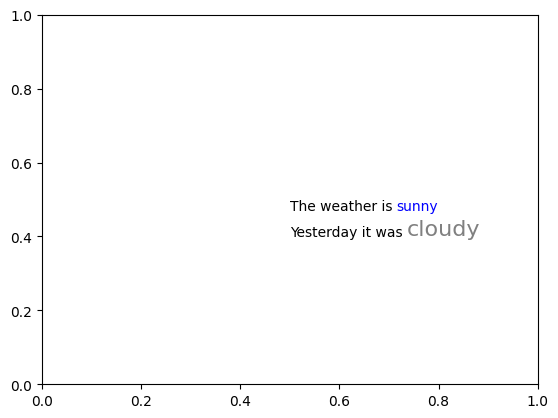

In [2]:
import matplotlib.pyplot as plt
from highlight_text import ax_text

fig, ax = plt.subplots()
ax_text(
    x=0.5,
    y=0.5,
    s="The weather is <sunny>\nYesterday it was <cloudy>",
    highlight_textprops=[
        {"color": "blue"},
        {"color": "grey", "fontsize": 16},
    ],
    ax=ax,
)